## 0. Imports/ Defining Fuctions for Tweepy & Extracting Tweet Features

In [1]:
from __future__ import print_function
import pandas as pd
import requests
from requests_oauthlib import OAuth1
import cnfg
import tweepy
from tweepy.models import Status, ResultSet
import re
from datetime import datetime
import random

In [2]:
config = cnfg.load(".twitter_config")

oauth = OAuth1(config["consumer_key"],
               config["consumer_secret"],
               config["access_token"],
               config["access_token_secret"])

auth = tweepy.OAuthHandler(config["consumer_key"],
                           config["consumer_secret"])
#auth = tweepy.AppAuthHandler(config["consumer_key"],
#                           config["consumer_secret"])

#auth.set_access_token(config["access_token"],
#                      config["access_token_secret"])

api=tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
def view_rate_limits():
	"""
	View's key rate limits for Twitter REST API with application authentication.
	"""

	rate_limit_dict = api.rate_limit_status()['resources'] #only one API call!

	follow_remain = rate_limit_dict["friends"]['/friends/list']['remaining']

	follow_reset_time = convert_UNIX_time(rate_limit_dict["friends"]['/friends/list']['reset'])

	search_remain = rate_limit_dict['search']['/search/tweets']['remaining']

	search_reset_time = convert_UNIX_time(rate_limit_dict['search']['/search/tweets']['reset'])

	application_remain = rate_limit_dict['application']['/application/rate_limit_status']['remaining']

	application_reset_time = convert_UNIX_time(rate_limit_dict['application']['/application/rate_limit_status']['reset'])

	user_remain = rate_limit_dict['statuses']['/statuses/user_timeline']["remaining"]

	user_reset = convert_UNIX_time(rate_limit_dict['statuses']['/statuses/user_timeline']["reset"])

	print("""
		Search Remaining: {}, Search Reset: {}

		Follow Remaining: {}, Follow Reset: {}

		User Remaining: {}, User Reset: {}

		Application Remaining: {}, Application Reset: {}

		The Current time is: {}
		""".format(search_remain, search_reset_time, follow_remain, follow_reset_time, user_remain, user_reset, application_remain, application_reset_time, datetime.now().time()))


def search_twitter(query, number):
	"""
	Argument Order: query, number

	Will search twitter for the query. Query can be a list.
	Number relates to how many tweets

	Returns a list of tweets
	"""
	assert type(query) == str, "Please enter a query in the form of a string"
	assert type(number) == int, "Please enter the number of as an integer"

	return list(tweepy.Cursor(api.search, q=query, lang='en', tweet_mode='extended').items(number))

def extract_handle(tweet):
	"""
	Argument Order: tweet

	Extracts the twitter handle for a given tweet. @ symbol not included.

	Returns the handle - string type
	"""
	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	return tweet.__dict__['user'].screen_name

def extract_text(tweet):
	"""
	Argument Order: tweet

	Extracts the clean text of a tweet. Remove links and emoji's
	Returns clean text of the tweet
	"""

	#this function can be mapped to a list of tweets (status type)

	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	regex = r"http\S+"
	subset = ""

	emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

	if hasattr(tweet, "text"):
		clean = re.sub(regex, subset, tweet.text.strip())
		clean = emoji_pattern.sub(subset, clean).strip()
	else:
		clean = re.sub(regex, subset, tweet.full_text.strip())
	return clean



def extract_hashtags(tweet):
	"""
	Argument Order: tweet

	Return a list of hastags present in a given tweet
	"""
	hashtags = []
	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	if hasattr(tweet, "entities"):
		if tweet.entities['hashtags'] == []:
			return []
		else:
			for i in tweet.entities['hashtags']:
				hashtags.append(i['text'])
	else:
		print("No entity method!")
	return hashtags


def extract_datetime(tweet):
	"""
	Argument Order: tweet

	Returns a datetime object
	"""
	assert type(tweet) == Status, "Please enter in a tweet of type Status"

	return tweet.created_at

def extract_users_tweets(handle, number):
	"""
	Argument Order: handle, number of tweets to extract
	
	Extract's a user's tweets
	"""
	final = ResultSet() #can change to resultset later if I want

	try:
		for status in tweepy.Cursor(api.user_timeline, screen_name=handle, count=200, include_rts=True).items(number):
			final.append(status)
	except:
		print("{} is a protected user!")
		return []

	return final


def average_retweets(lst, handle):
	"""
	Argument Order: lst, handle

	Given a ResultSet of tweets, calculate the average retweet count for all tweets in ResultSet.

	Be sure to only apply this on a ResultSet that excludes retweets.

	This function would be amazing with firehose API
	"""
	assert type(lst) == ResultSet, "Please enter a ResultSet of user's tweets."

	count = 0
	
	for tweet in lst:
		count += tweet.retweet_count

	return count/len(lst)

def get_all_following(handle):
	"""
	Argument Order: handle

	Returns all the followers for a particular handle.

	Warning: This burns through rate limit
	"""
	final = []

	for friend in tweepy.Cursor(api.friends, screen_name=handle, count=200).items():
		final.append(friend.screen_name)
	return final

def get_100_following(handle):
	"""
	Argument Order: handle

	Returns the 100 most recent handles that the specified user followed.

	This function has been optimised for rate limiting.

	NOTE: If given access to firehose API - this function could be altered slightly to obtain all friends.
	"""

	final = []

	try:
		for friend in tweepy.Cursor(api.friends, screen_name=handle, count=100).items(100):
			final.append(friend.screen_name)
	except:
		print("Skipping - {} has protected tweets!".format(handle))
		return []

	return final

def second_layer_following(lst):
	"""
	Argument Order: lst

	For a given list of twitter handles, extract who they follow.

	This function will only extract the first 100 of followers for a given handle - this is due to rate limiting.

	This function will return a 'flat' list of all followers.

	NOTE: If given access to firehose API - this function could be altered slightly to obtain the entire secondary layer
	"""
	cnt = 0

	second_layer = []

	for handle in lst:
		print("processing {}".format(handle))
		second_layer.append(get_100_following(handle))
		print()
		cnt+= 1
		if cnt%10 == 0:
			print()
			print("processed {} handles from a total of {}".format(cnt, len(lst)))
			print()

	flat_second_layer = sum(second_layer, [])

	return flat_second_layer

def random_sample_lst(lst):
	"""
	Argument Order: lst

	Extracts the a random 25% of a given list
	"""
	return random.sample(lst, len(lst)//4)

def distinct(lst1, lst2):
	"""
	Argument order: source following list, accumulated source's following list
	"""

	following = lst1

	second_layer_following = lst2

	unique = set(following)

	final = [x for x in second_layer_following if x not in unique]

	return final

def convert_UNIX_time(timestamp):
    assert type(timestamp) == int, "Ensure the unix timestamp is an integer"

    return datetime.fromtimestamp(timestamp).time()

def tweet_cleaner(tweet_text):
    clean_tweets = []
    for text in tweet_text:
        clean_tweets.append(p.clean(text))

    import string
    translator = str.maketrans('', '', string.punctuation)

    tweets = []
    for text in clean_tweets:
        tweets.append((str(text).translate(translator)))  

    tweet = []
    for words in tweets:
        tweet.append(words.lower())

    wordnet_lemmatizer = WordNetLemmatizer()
    final_tweets = []
    for words in tweet:
        final_tweets.append(wordnet_lemmatizer.lemmatize(words))
    return(final_tweets)

## 1. Gathering Tweets/Extracting Features & Cleaning Tweet Text

In [5]:
import preprocessor as p
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import spacy
import nltk
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models, similarities, matutils
import gensim
import pyLDAvis
import pyLDAvis.gensim
from collections import Counter
from gensim.corpora.dictionary import Dictionary
#nlp = spacy.load('en')
import pickle
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk_stopwords = stopwords.words("english")+["health",'healthy','fitness','food','...','dont','follow','good','new','good','giving','get','like','share','week','pron','please','today','day','monday','sunday',"week","fit","amp",'february',"-pron-","rt", "via","-»","--»","--","---","-->","<--","->","<-","«--","«","«-","»","«»"]

In [10]:
fit_tweets = search_twitter('#fitness', 25000)

Rate limit reached. Sleeping for: 821
Rate limit reached. Sleeping for: 821
Rate limit reached. Sleeping for: 816
Rate limit reached. Sleeping for: 813


In [61]:
len(final_tweets)

102071

Save/load data to/from pickle file

In [12]:
#import pickle
#with open('new_health_tweets.pkl', 'wb') as f:
#    pickle.dump(fit_tweets, f)

In [14]:
with open('nutrition_tweets.pkl', 'rb') as f:
    nutrition_tweets = pickle.load(f)

In [16]:
with open('nutrition_tweets2.pkl', 'rb') as f:
    nutrition_tweets2 = pickle.load(f)

In [ ]:
with open('nutrition_tweets2.pkl', 'rb') as f:
    nutrition_tweets2 = pickle.load(f)

In [44]:
with open('new_health_tweets.pkl', 'rb') as f:
    health_tweets3 = pickle.load(f)

In [45]:
with open('Tweets2.pkl', 'rb') as f:
    fit_tweets = pickle.load(f)

In [52]:
fit_tweets = pd.read_csv('Tweets2.csv')

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [51]:
hashtags = []

for tweet in fit_tweets:
    hashtags.append(extract_hashtags(tweet))

tweet_text = []

for tweet in fit_tweets:
    tweet_text.append(extract_text(tweet))
    
date_time = []

for tweet in fit_tweets:
    date_time.append(extract_datetime(tweet))
    
handle = []

for tweet in fit_tweets:
    handle.append(extract_handle(tweet))
    
location = []
for tweet in fit_tweets:
    location.append(tweet.place)
    

AssertionError: Please enter in a tweet of type Status

In [47]:
hashtags2 = []

for tweet in health_tweets3:
    hashtags2.append(extract_hashtags(tweet))

tweet_text2 =[]

for tweet in health_tweets3:
    tweet_text2.append(extract_text(tweet))
    
date_time2 = []

for tweet in health_tweets3:
    date_time2.append(extract_datetime(tweet))
    
handle2 = []

for tweet in health_tweets3:
    handle2.append(extract_handle(tweet))
    
location2 = []
for tweet in health_tweets3:
    location2.append(tweet.place)

#### Build Dataframe (if not already) from Extracted Tweets/Features 

In [39]:
df = pd.DataFrame()
df["text"] = tweet_text
df["datetime"]= date_time
df["location"] = location
df["hashtags"] = hashtags
df["handle"] = handle

In [40]:
df2 = pd.DataFrame()
df2["text"] = tweet_text2
df2["datetime"]= date_time2
df2["location"] = location2
df2["hashtags"] = hashtags2
df2["handle"] = handle2

Creating our dataframe from pickled round of health tweets

Let's combine (concac) our dataframes for analysis

In [53]:
frames = [df_health,df_health2,df_health3]

In [54]:
master_df = pd.concat(frames)

In [57]:
tweet_text = master_df['text']

In [68]:
#master_df['location'].value_counts()

#### Cleaning Tweet Text

In [58]:
tweets = list(map(lambda x: x.replace("#", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("&amp;", "&"), tweets))
tweets = list(map(lambda x: x.replace("&gt;", "greater than"), tweet_text))
tweet_text = list(map(lambda x: x.replace("&lt;", "less than"), tweets))
tweets = list(map(lambda x: x.replace("&amp;", "&"), tweet_text))
tweet_text = list(map(lambda x: x.replace("/", ""), tweets))
tweets = list(map(lambda x: x.replace("...", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("\u200d", ""), tweets))
tweets = list(map(lambda x: x.replace("\U0001f986", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("\U0001f942", ""), tweets))
tweets = list(map(lambda x: x.replace("\U0001f92f", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("\U0001f911", ""), tweets))
tweets = list(map(lambda x: x.replace("$", ""), tweet_text))
tweet_text = list(map(lambda x: x.replace("n't", ""), tweets))
tweets = list(map(lambda x: x.replace("ç", "c"), tweet_text))
tweet_text = list(map(lambda x: x.replace("'ll", ""), tweets))

In [59]:
final_tweets = tweet_cleaner(tweet_text)

In [60]:
final_tweets[12]

'registration for grow babies grow is now open do miss out on this exciting opportunity to tackle one of the most critical and modifiable factors for the longterm health and neurodevelopment of your smallest babies growbabiesgrow nutrition'

## 2. Topic Modeling with LDA/NMF and Word2Vec

#### Imports & Pre-Processing 

In [89]:
import numpy as np
from scipy.misc import imread
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set_style("darkgrid")

In [70]:
### EXAMPLE ONLY FROM SKLEARN
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=10,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_features=2000,
                                stop_words=nltk_stopwords)
tf = tf_vectorizer.fit_transform(final_tweets)

In [71]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [72]:
lda = LatentDirichletAllocation(n_components=15, max_iter=5,
                                learning_offset=50.,random_state=0).fit(tf)

/Users/hector/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [73]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [132]:
n_top_words = 100
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
beauty nutrition love success happy going cancer keep every recipes someone giveaway kindle look stop see never things enter breakfast scientists days away without working delicious let would tvtime stay quote news month international times report around talk answer socialmedia nationalnutritionmonth believe secrets track total problems growth mma brand must lost hardbody yes celebrate three access runners proper selfimprovement offers relax deadly trend ketogenic almost fridayfeeling national million offer iron question global hear bowl months sun policy harder sunshine serious face bacteria winner pizza athletic left pounds starting lots motivated stories late else talking decided bit needed lovers sound congress
Topic #1:
nutrition heart water sleep start care part benefits trainer everyone boost therapy runner drink short healthier podcast pregnancy community system immune helps nature two cry weeks coffee butter memory started winter mia move discover drinking nutritiona

In [133]:
topic_0 = 'beauty nutrition love success happy going cancer keep every recipes someone giveaway kindle look stop see never things enter breakfast scientists days away without working delicious let would tvtime stay quote news month international times report around talk answer socialmedia nationalnutritionmonth believe secrets track total problems growth mma brand must lost hardbody yes celebrate three access runners proper selfimprovement offers relax deadly trend ketogenic almost fridayfeeling national million offer iron question global hear bowl months sun policy harder sunshine serious face bacteria winner pizza athletic left pounds starting lots motivated stories late else talking decided bit needed lovers sound congress'

Now, let's create a WordClous for more intuitive visualization

In [112]:
from wordcloud import WordCloud, STOPWORDS

In [134]:
def create_wordcloud(text):
    wc = WordCloud(background_color = "white",
                   max_words=100)
    wc.generate(text)
    
    wc.to_file('test.png')

In [135]:
create_wordcloud(topic_0)

In [110]:
component_dicts = []
lda_feature_names = tf_vectorizer.get_feature_names()
components = lda.components_
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tf_feature_names, components[index]))

    print(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words], "\n")
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words]))

topic 0
[('beauty', 2225.1509738185327), ('nutrition', 2219.699537356515), ('love', 2138.7857955552317), ('success', 1952.890536280965), ('happy', 1469.694655809243), ('going', 1352.5295851900898), ('cancer', 1341.7163702002779), ('keep', 1162.5510378316662), ('every', 1152.6378016356498), ('recipes', 1060.8938465841022)] 

topic 1
[('nutrition', 1472.2563483842962), ('heart', 1446.0183154030565), ('water', 1414.8336080589368), ('sleep', 1367.7477817832723), ('start', 1323.5171629393535), ('care', 1059.0821438166945), ('part', 722.6845542122967), ('benefits', 589.9376611348671), ('trainer', 571.8480722794274), ('everyone', 564.3618298594756)] 

topic 2
[('vegan', 3273.421190233193), ('weightloss', 2827.5347127070286), ('diet', 2772.11192658411), ('nutrition', 2126.6497005448323), ('training', 2082.803904197645), ('healing', 1385.6300163035771), ('daily', 1276.7449987735095), ('strength', 1219.2561325199342), ('win', 1123.9225960534095), ('amazing', 994.1000146962112)] 

topic 3
[('exer

ValueError: could not convert string to float: 'v'

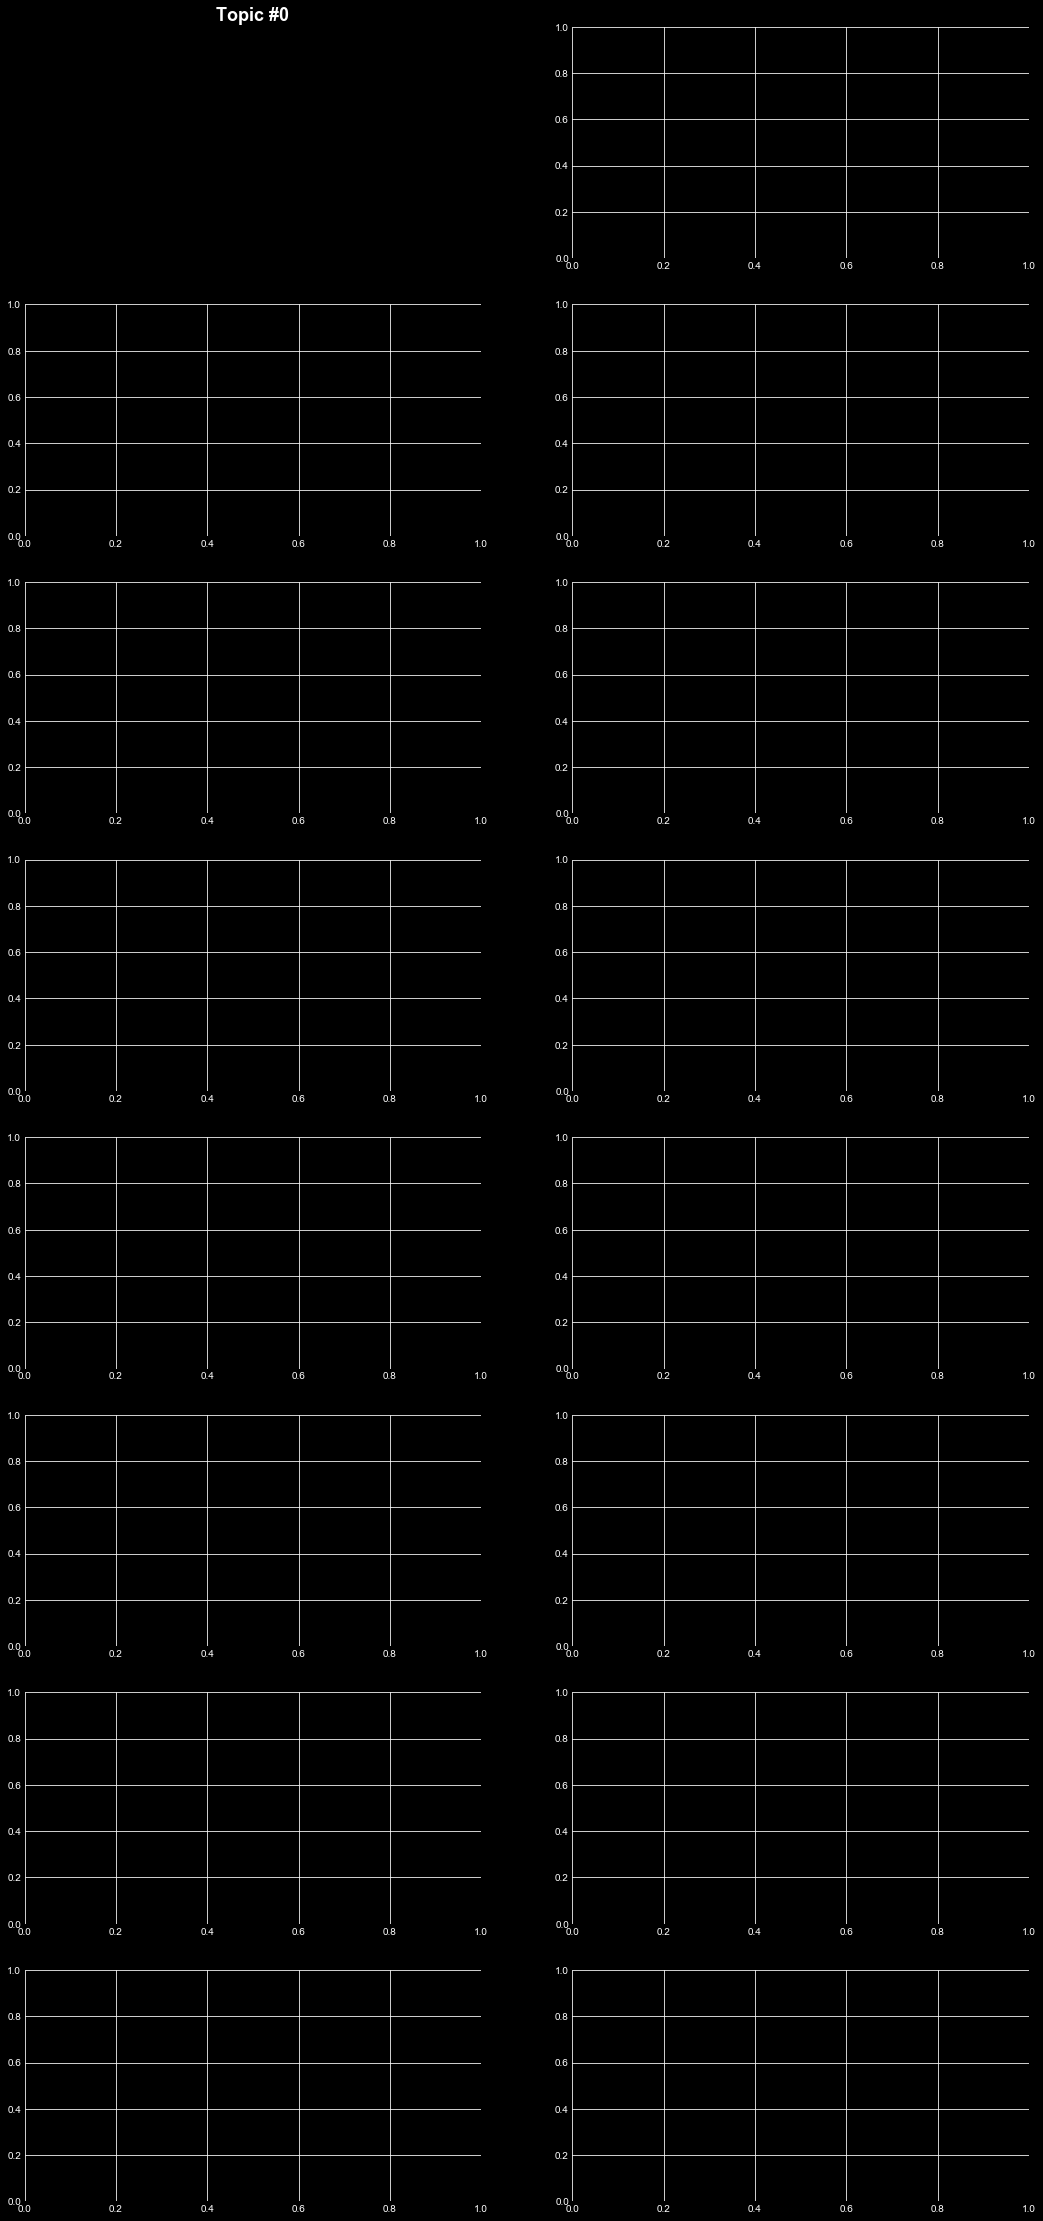

In [115]:
# Create topic word clouds
plt.style.use('dark_background')

ncol = 2
nrow = int(np.ceil(len(component_dicts) / ncol))

figwidth = ncol * 9
figheight = nrow * 5
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(len(component_dicts)): 
    curr_ax = fig.sca(ax[t])
    curr_ax.set_title('Topic #%d' % t, fontsize=18, fontweight='bold')
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])
#     curr_ax.set_axis_on(0)    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))
    
fig.tight_layout(rect=(0, 0, 1, 0.975))
fig.suptitle('LDA Topic Clouds', fontsize=24, fontweight='bold');

In [116]:
for t in range(len(component_dicts)): 
    curr_ax = fig.sca(ax[t])
    curr_ax.set_title('Topic #%d' % t, fontsize=18, fontweight='bold')
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])
#     curr_ax.set_axis_on(0)    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))

ValueError: could not convert string to float: 'v'

In [119]:
# old gensim func, delete if not used
# helper function to create word clouds
def create_wordcloud(text_list, mask, filename, n_words=100):
    wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, mask=mask, max_font_size=100, max_words=n_words, width=600, height=600)
    wordcloud.generate(" ".join(text_list))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    if filename:
        plt.savefig(filename, dpi=600)
    plt.show();

In [121]:
Mindful_Mask = imread('Meditation-Silhouette.jpg')

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Users/hector/anaconda/lib/python3.6/site-packages/scipy/misc/pilutil.py:165: DeprecationWarning: `fromimage` is deprecated!
`fromimage` is deprecated in SciPy 1.0.0. and will be removed in 1.2.0.
Use ``np.asarray(im)`` instead.
  return fromimage(im, flatten=flatten, mode=mode)


In [131]:
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline  

for t in range(15):
    plt.figure()
    plt.imshow(WordCloud().fit_words(components(t, 200)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

TypeError: 'numpy.ndarray' object is not callable

<Figure size 432x288 with 0 Axes>

#### LDA with pyLDAvis

In [75]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [76]:
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/Users/hector/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     9.617545        1       1  0.288351  0.058628
14     7.747181        1       2  0.009828 -0.211253
7      7.686167        1       3  0.016294 -0.156461
13     7.032027        1       4 -0.068435 -0.062843
2      6.849860        1       5  0.210999 -0.187887
0      6.800616        1       6 -0.101513  0.045788
9      6.742900        1       7 -0.107151  0.106101
11     6.506314        1       8 -0.138193 -0.069491
4      6.484311        1       9  0.129773  0.231867
3      6.327522        1      10  0.198341  0.037929
8      5.894427        1      11 -0.068781  0.051551
12     5.773243        1      12 -0.131853 -0.122666
5      5.641737        1      13 -0.088221  0.010844
6      5.619800        1      14 -0.073774  0.244948
1      5.276349        1      15 -0.075667  0.022946, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
1930  Default   8387.000000        wellness   8387.000000  30.0000  30.0000
449   Default  10219.000000            diet  10219.000000  29.0000  29.0000
687   Default   5903.000000            full   5903.000000  28.0000  28.0000
1964  Default   9046.000000         workout   9046.000000  27.0000  27.0000
399   Default   5407.000000  cryptocurrency   5407.000000  26.0000  26.0000
1624  Default   5331.000000        solution   5331.000000  25.0000  25.0000
1148  Default   4962.000000          mobile   4962.000000  24.0000  24.0000
869   Default   5120.000000             ico   5120.000000  23.0000  23.0000
1140  Default   4659.000000          mining   4659.000000  22.0000  22.0000
575   Default   5942.000000        exercise   5942.000000  21.0000  21.0000
768   Default   4491.000000      gymrewards   4491.000000  20.0000  20.0000
85    Default   4422.000000             app   4422.000000  19.0000  19.0000
764   Default   5462.000000             gym   5462.000000  18.0000  18.0000
1012  Default   4602.000000       lifestyle   4602.000000  17.0000  17.0000
568   Default   3564.000000        exchange   3564.000000  16.0000  16.0000
577   Default   3684.000000      exercising   3684.000000  15.0000  15.0000
1873  Default   3649.000000           vegan   3649.000000  14.0000  14.0000
502   Default   3715.000000             eat   3715.000000  13.0000  13.0000
1923  Default   5136.000000      weightloss   5136.000000  12.0000  12.0000
1165  Default   3959.000000      motivation   3959.000000  11.0000  11.0000
1009  Default   3400.000000            life   3400.000000  10.0000  10.0000
287   Default   2994.000000           check   2994.000000   9.0000   9.0000
675   Default   3257.000000            free   3257.000000   8.0000   8.0000
169   Default   3262.000000            best   3262.000000   7.0000   7.0000
1986  Default   2995.000000            yoga   2995.000000   6.0000   6.0000
662   Default   3070.000000           foods   3070.000000   5.0000   5.0000
1220  Default  34049.000000       nutrition  34049.000000   4.0000   4.0000
1192  Default   2531.000000            need   2531.000000   3.0000   3.0000
1242  Default   2587.000000             one   2587.000000   2.0000   2.0000
821   Default   2935.000000            help   2935.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
1772  Topic15    617.673592         therapy    618.662427   2.9403  -4.1926
1507  Topic15    591.329880          runner    592.318714   2.9403  -4.2362
1579  Topic15    548.148756           short    549.137592   2.9401  -4.3120
795   Topic15    515.113884       healthier    516.102718   2.9400  -4.3742
1330  Topic15    499.072994         podcast    500.061828   2.9400  -4.4058
1351  Topic15    495.826279       pregnancy    496.815112   2.9399  -4.4123
342   Topic15    490.605950       community    491.594785   2.9399  -4.4229
876   Topic15   

In [77]:
py_vis = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.save_html(py_vis, 'py_vis.html')

/Users/hector/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


#### Next, let's try Word2Vec using Gensim

In [78]:
texts = [[word for word in document.lower().split() if word not in nltk_stopwords]
         for document in final_tweets]

In [79]:
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=25, workers=4,sg=1)

We'll also create a second, more selective model for visualizations

In [93]:
model2 = gensim.models.Word2Vec(texts, size=100, window=5, min_count=500, workers=4,sg=1) 

Let's explore our first model & vocab

In [81]:
list(model.wv.vocab.items())[:15]

[('join', <gensim.models.keyedvectors.Vocab at 0x1a4aadcf98>),
 ('talk', <gensim.models.keyedvectors.Vocab at 0x1a4aadcef0>),
 ('things', <gensim.models.keyedvectors.Vocab at 0x1a4aadce10>),
 ('nutrition', <gensim.models.keyedvectors.Vocab at 0x1a4aadce80>),
 ('question', <gensim.models.keyedvectors.Vocab at 0x1a4aadce48>),
 ('use', <gensim.models.keyedvectors.Vocab at 0x1a4aae6278>),
 ('stress', <gensim.models.keyedvectors.Vocab at 0x1a4aae6240>),
 ('make', <gensim.models.keyedvectors.Vocab at 0x1a4aae6208>),
 ('fat', <gensim.models.keyedvectors.Vocab at 0x1a4aae61d0>),
 ('researchers', <gensim.models.keyedvectors.Vocab at 0x1a4aae6198>),
 ('found', <gensim.models.keyedvectors.Vocab at 0x1a4aae6160>),
 ('high', <gensim.models.keyedvectors.Vocab at 0x1a4aae6128>),
 ('blood', <gensim.models.keyedvectors.Vocab at 0x1a4aae60f0>),
 ('pressure', <gensim.models.keyedvectors.Vocab at 0x1a4aae60b8>),
 ('higher', <gensim.models.keyedvectors.Vocab at 0x1a4aae6080>)]

In [99]:
model.most_similar('vegetarian' ,topn=8)

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vegetarians', 0.7022767663002014),
 ('mediterranean', 0.6839292049407959),
 ('plantbased', 0.6799337863922119),
 ('vegansofig', 0.6577439904212952),
 ('veganism', 0.6378093957901001),
 ('vegans', 0.6376033425331116),
 ('wholegrains', 0.6319670081138611),
 ('🤓', 0.6241117119789124)]

In [83]:
model.similarity('yoga','strength')

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.341995896174861

In [84]:
# Compute cosine_similarity
model.n_similarity(['woman', 'girl'], ['man', 'wellness'])

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  


0.43812958271257657

In [85]:
model.doesnt_match("yoga foods crossfit warrior".split())

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'foods'

Great, now let's visualiz our Word2Vec results:

In [86]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('health_tweets3.png')
    plt.show()

In [105]:
def tsne_plot2(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    sns.despine(left='False')
    #sns.set(yticks=[])
    #sns.set(xticks=[])
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('health_tweets4.png')
    plt.show()

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationW

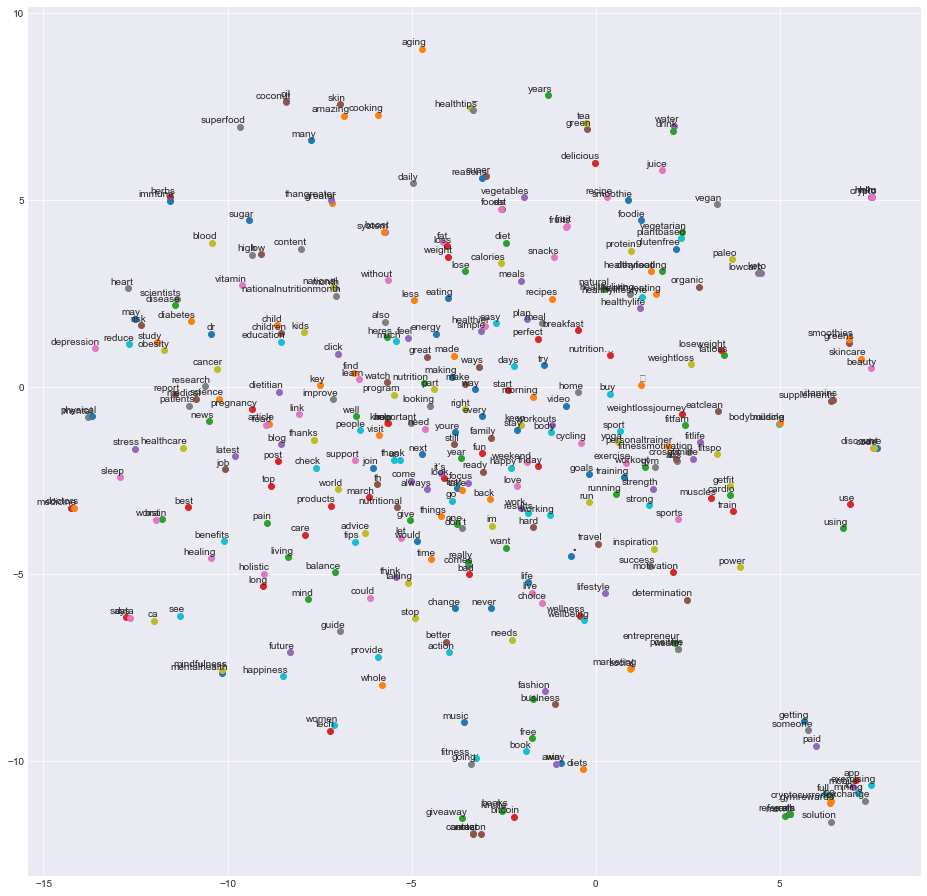

In [94]:
tsne_plot(model2)

/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/hector/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed

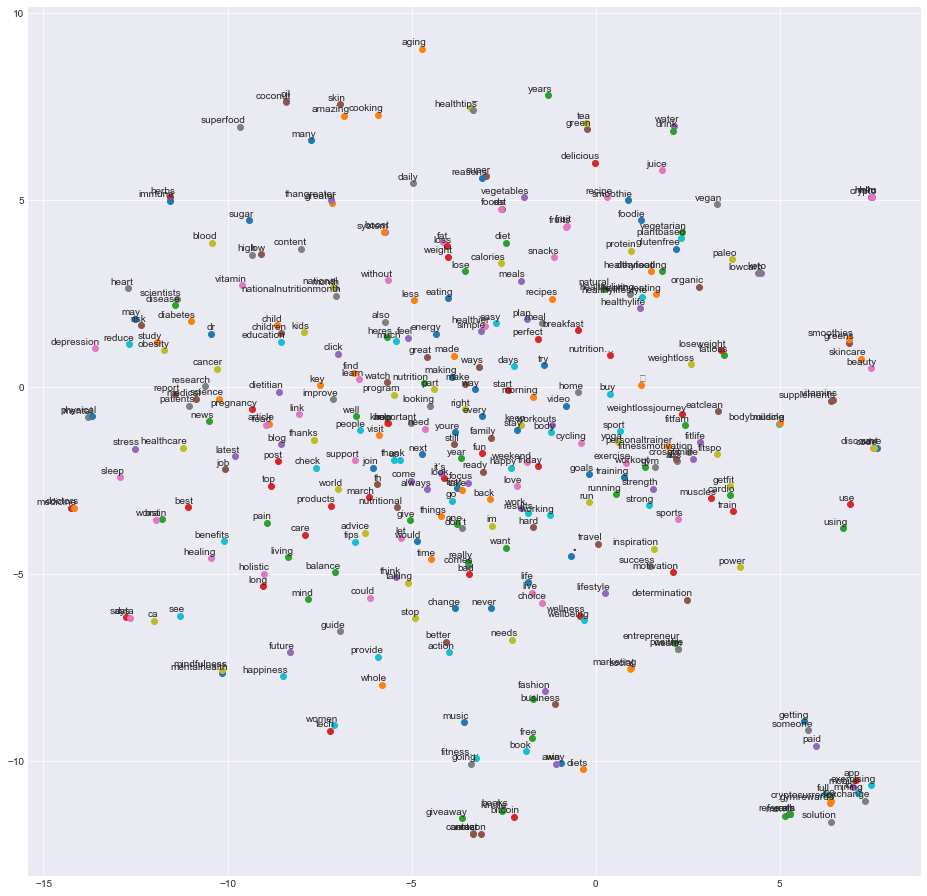

In [106]:
tsne_plot2(model2)

#### Finally, Let's try a different approach to topic modeling: TFIDF+NMF

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn import metrics
import matplotlib.pyplot as plt

TFIDF Vectorization

In [142]:
tfidf_vectorizer = TfidfVectorizer(max_features=25000, stop_words=nltk_stopwords, ngram_range=(0,2))

tfidf_matrix = tfidf_vectorizer.fit_transform(final_tweets) #try .todense9#fit the vectorizer to synopses

print(tfidf_matrix.shape)

(102071, 25000)


In [143]:
terms = tfidf_vectorizer.get_feature_names()

NMF Topic Model

In [144]:
n_samples = 2000
n_features = 1000
n_topics = 15
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [145]:
nmf = NMF(n_components=15, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_matrix)

In [146]:
# Taking a look at our Features/Topics
print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
 nutrition diet wellness body weightloss help life love great eating one time know make healthyeating weight benefits us protein
Topic #1:
 solution mobile mobile app app mining mining mobile app ico cryptocurrency solution full cryptocurrency ico full cryptocurrency exercising exchange mining exercising exchange solution exercising full gymrewards gymrewards ico
Topic #2:
 foods nutrition eat vegetables reasons eat vegetables super super foods reasons super vegetables diet vegan nutrition diet vegan eat foods diet nutrition diet nutrition eat everyday everyday nutrition diet mindbody
Topic #3:
 lifestyle nutrition mlm organic lifestyle nutrition mlm hh4u hh4u organic medicine hh4u hugging hugging medicine mlm cry cry organic lifestyle medicine nutrition mlm crypto crypto btc crypto btc
Topic #4:
 earn eth eth referrals solution mo referrals gymrewards eth referrals mo earn gymrewards gymrewards ico ico ico full full cryptocurrency cryptocurrency solutio

## 3. Clustering: K-means & Hierarchical

In [147]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [148]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

In [149]:
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

#### K-Means Clustering

fit nmf topics for kmeans clustering

In [150]:
reduced_tweets = tfidf_vectorizer.fit_transform(final_tweets)

In [151]:
nmf_reduced = nmf.fit_transform(reduced_tweets)

In [152]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(terms, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('abstainfromfood nutrition', 2225.1509738185327), ('australians', 2219.699537356515), ('arsenic', 2138.7857955552317), ('bell guest', 1952.890536280965), ('andy warhol', 1469.694655809243), ('american digitalmarketing', 1352.5295851900898), ('action', 1341.7163702002779), ('apply eujobs', 1162.5510378316662), ('ais webinar', 1152.6378016356498), ('ball', 1060.8938465841022), ('bedside bedroom', 972.1948099504725), ('amazon store', 947.2025656201325), ('approach read', 945.957258458129), ('around essex', 923.3411348430711), ('behealthy cannabis', 915.1466923725442), ('bc', 903.7980996703587), ('attention nutrition', 877.151537281523), ('best arm', 802.6367318762464), ('aims fill', 796.2371003107988), ('achieve bette', 735.5239355616072)] 

topic 1
[('australians', 1472.2563483842962), ('announced', 1446.0183154030565), ('bhivelabs bhive', 1414.8336080589368), ('beauty skincare', 1367.7477817832723), ('beginning end', 1323.5171629393535), ('actions upending', 1059.0821438166945

In [153]:
ns = np.arange(3, 15, 1)
inertias = []
silhouettes = []

for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=123)
    kmeans.fit(reduced_tweets)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # only a sample was used to calculate silhouette score because of memory errors
    silhouettes.append(silhouette_score(nmf_reduced, labels, metric='cosine', sample_size=5000))

/Users/hector/anaconda/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


First, let's turn our matrix into a dataframe

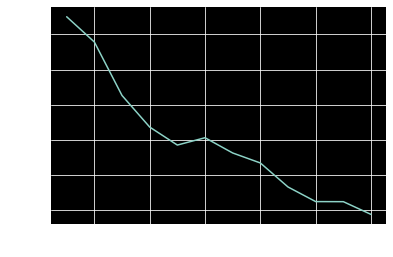

In [154]:
# plot the inertia scores and look for the kink in the curve
plt.plot(ns, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia')
plt.savefig('5_clusters_inter.png');

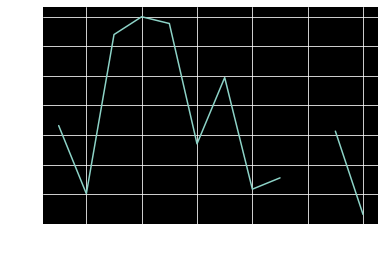

In [155]:
# plot the silhouettte scores
plt.plot(ns, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score')
plt.savefig('5_clusters_silhouette.png');

In [156]:

# based on inertia and silhouette scores, a cluster size of 6 was selected
kmeans = KMeans(n_clusters=8, init="k-means++", random_state=824)
kmeans.fit(reduced_tweets)
tweet_labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))
print("Silhouette score: {}".format(silhouette_score(reduced_tweets, tweet_labels, metric='cosine', sample_size=5000, random_state=824)))

Inertia score: 82218.00876077796
Silhouette score: 0.00456316950326696


In [157]:
tweet_word_list = tfidf_vectorizer.get_feature_names()
#components = reduced_tweets.components_
tweet_labels = kmeans.labels_

#### Visualizing Clusters

In [158]:
df_reduced = pd.DataFrame(nmf_reduced)
df_reduced['tweets'] = final_tweets
df_reduced['labels'] = tweet_labels

In [159]:
df_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,tweets,labels
0,0.013965,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,join and now to talk all things nutrition hav...,3
1,0.010621,0.0,0.000000,0.0,0.0,0.000472,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,can stress make you fat nutrition,3
2,0.018911,0.0,0.000529,0.0,0.0,0.000000,0.000000,0.0,0.001707,0.0,0.0,0.0,0.0,0.0,0.0,researchers have found a correlation between h...,0
3,0.012357,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,march is nutrition month watch at midday with...,3
4,0.017409,0.0,0.000000,0.0,0.0,0.000000,0.004616,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,join and now to talk all things nutrition have...,0


In [160]:
# examine the number of reviews for in each cluster
for cluster in range(len(set(tweet_labels))):
    print("Cluster {} has {} tweets.".format(cluster, sum(tweet_labels==cluster)))

Cluster 0 has 39124 tweets.
Cluster 1 has 526 tweets.
Cluster 2 has 994 tweets.
Cluster 3 has 56029 tweets.
Cluster 4 has 70 tweets.
Cluster 5 has 1516 tweets.
Cluster 6 has 296 tweets.
Cluster 7 has 3516 tweets.


In [161]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=824)
tsne_tweets = tsne.fit_transform(nmf_reduced)

In [225]:
df_tsne_tweets = pd.DataFrame(tsne_tweets, columns=["tsne_x", "tsne_y"])
df_tsne_tweets["Cluster"] = tweet_labels
df_tsne_tweets.shape

(34134, 3)

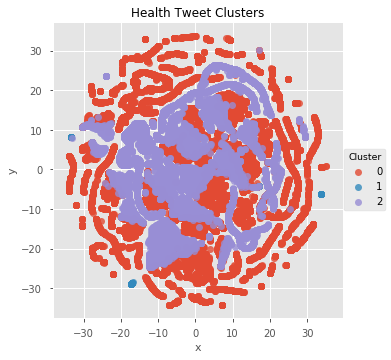

In [226]:
# visualize the tweets review clusters using t-SNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
#np.random.seed(sum(map(ord, "aesthetics")))
sns.set_context('notebook')

tsne_tweets = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_tweets, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Health Tweet Clusters");

#### Plotting our K-means clusters in 3-D

In [131]:
print(__doc__)

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import numpy as np

from sklearn.cluster import KMeans
from sklearn import datasets

Automatically created module for IPython interactive environment


In [415]:

import plotly.plotly as py
import pandas as pd


scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",    
    x = df_reduced['labels'], y = df['y'], z = df['z'],
    marker = dict( size=2, color="rgb(23, 190, 207)" )
)
clusters = dict(
    alphahull = 7,
    name = "y",
    opacity = 0.1,
    type = "mesh3d",    
    x = df['x'], y = df['y'], z = df['z']
)
layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),
    )
)
fig = dict( data=[scatter, clusters], layout=layout )
# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d point clustering')

(12, 25000)

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

centroids : 
[[ 1.84723350e-02  7.51714067e-04  5.70892824e-04  6.79476678e-04
   3.78313323e-04  1.73770405e-04  8.60897261e-04  3.34130809e-04
   6.35759070e-04  1.78282304e-04  2.72959567e-04  5.83424487e-04
   2.53706945e-04  4.26602707e-04  4.25112076e-05]
 [ 4.31103445e-03  7.78777353e-06 -1.73472348e-18 -4.98732999e-18
   1.84638930e-01 -3.46944695e-18  5.41627726e-06 -1.51788304e-18
   1.95156391e-18  1.08420217e-18 -3.25260652e-19 -2.16840434e-18
  -1.95156391e-18  8.67361738e-19 -1.08420217e-18]
 [ 4.06087074e-03  6.93889390e-18  2.16840434e-18  1.46169413e-01
   4.55364912e-18 -3.90312782e-18 -5.63785130e-18 -1.51788304e-18
   1.95156391e-18  3.36102673e-18 -3.25260652e-19  1.95156391e-18
  -3.68628739e-18  8.67361738e-19  1.30104261e-18]
 [ 2.40499990e-03  5.63785130e-18  4.07625669e-05 -4.77048956e-18
   2.60208521e-18  1.91770481e-01 -5.20417043e-18 -1.51788304e-18
   1.95156391e-18  1.08420217e-19 -2.16840434e-19 -2.16840434e-18
  -1.08420217e-18  8.67361738e-19 -8.67361

IndexError: list index out of range

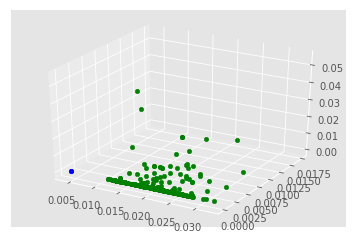

In [146]:
cluster_num = 15
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print("centroids : ")
print(centroids)
print("labels : ")
print(labels)

colors = ["g.","r.","c.","y."]

color = ["g", "r", "b","purple",'brown',"pink","orange"]

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')


for i in range(len(nmf_reduced)):
#    print("coordinate:",nmf_reduced[i], "label:", labels[i])
#    print("i : ",i)
#    print("color[labels[i]] : ",color[labels[i]])
    ax.scatter(nmf_reduced[i][0], nmf_reduced[i][1], nmf_reduced[i][2], c=color[labels[i]])


#for cluster_number in range(cluster_num):
#    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2], centroids[:, 3], centroids[:, 4], centroids[:, 5], marker = "x", s=150, linewidths = 5, zorder = 100, c=color)

plt.show()

In [168]:
import plotly.plotly as py
import plotly.graph_objs as go
py.tools.set_credentials_file(username='hectorhcuevas', api_key='Cuevas432')

AttributeError: module 'plotly.plotly' has no attribute 'tools'

In [165]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/iris.csv')
df.head()

data = []
clusters = []
colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(77,175,74)']

for i in range(len(df['Name'].unique())):
    name = df['Name'].unique()[i]
    color = colors[i]
    x = df[ df['Name'] == name ]['SepalLength']
    y = df[ df['Name'] == name ]['SepalWidth']
    z = df[ df['Name'] == name ]['PetalLength']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )
    
    cluster = dict(
        color = color,
        opacity = 0.3,
        type = "mesh3d",    
        x = x, y = y, z = z )
    data.append( cluster )

layout = dict(
    width=800,
    height=550,
    autosize=False,
    title='Iris dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)

# IPython notebook
# py.iplot(fig, filename='pandas-3d-scatter-iris', validate=False)

url = py.plot(fig, filename='pandas-3d-scatter-iris', validate=False)

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? support@plot.ly


Add our k-means labels to the datafram for plotting:

In [ ]:
df_km['category'] = km.labels_

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw(ax, df):
    colormap = { 0: 'red', 1: 'green', 2: 'blue', 3: 'orange' }
    colors = df_km.apply(lambda row: colormap[row.category], axis=1)

    ax.scatter(df['fish'], df['penni'], df['cat'], c=colors, s=100, alpha=0.5)
    ax.set_xlabel('Fish')
    ax.set_ylabel('Penni')
    ax.set_zlabel('Cat')

chart_count_vert = 5
chart_count_horiz = 5
number_of_graphs = chart_count_vert * chart_count_horiz

fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

for i in range(number_of_graphs):
    ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
    draw(ax, df)

#### Finally, Let's try Hierarchical clustering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(nmf_reduced)

Using scipy pdist instead!


In [188]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import mpl_toolkits.mplot3d.axes3d as p3
from __future__ import print_function, division
from builtins import range
import time

In [193]:
###Lazy Programmer Method! Sample Data for Faster Results
X = tfidf_vectorizer.fit_transform(final_tweets).todense()
N = tf.shape[0]
idx = np.random.choice(N, size=5000, replace=False) # subsampe for efficiency
x = X[idx]

In [194]:
dist_array = pdist(x, 'cosine') ## Cosine dist

In [191]:
dist_array

array([0.        , 0.59047845, 0.98787451, ..., 0.        , 0.98787451,
       0.98787451])

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist_array) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=labels, p = 12, truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
#k_clusters = range(2,20)
#ax1.plot(k_clusters, Sil_coefs)
#ax1.set_xlabel('number of clusters')
#ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
#ax2.plot(k_clusters, SSEs)
#ax2.set_xlabel('number of clusters')
#ax2.set_ylabel('SSE');

In [443]:
km.cluster_centers_.argsort()[:, ::-1]

array([[20989,     0, 19552, ..., 16665, 16666, 12499],
       [    0, 23415, 14283, ...,  7644,  7869,  6278],
       [    0, 19593, 17883, ..., 16662, 16663, 12499],
       [    0, 22772,  2034, ..., 16641, 16642, 12499],
       [    0, 19927,  1343, ..., 16667, 16668, 12499],
       [    0, 23300, 23289, ..., 16585, 16586, 12499]])

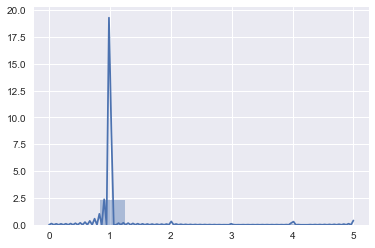

In [432]:
### Viewing Cluster Distribution
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
%matplotlib inline

plt.autoscale()
sns.distplot(km.labels_, bins=12)
plt.show()

Print out the top words in our clusters

In [446]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :3]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: success  seems connected
Cluster 1:  wellness nutrition
Cluster 2:  selfies time psychologists think
Cluster 3:  vegetable bowl
Cluster 4:  silicon beating beating heart
Cluster 5:  weight loss weight


IndexError: index 6 is out of bounds for axis 0 with size 6

Transform TFIDF Matrix with TSNE for Visualization of K-Mean Clusters

In [447]:
k = 12
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(tfidf_matrix)

In [448]:
tfs_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfs_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21295 samples in 0.020s...
[t-SNE] Computed neighbors for 21295 samples in 6.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21295
[t-SNE] Computed conditional probabilities for sample 2000 / 21295
[t-SNE] Computed conditional probabilities for sample 3000 / 21295
[t-SNE] Computed conditional probabilities for sample 4000 / 21295
[t-SNE] Computed conditional probabilities for sample 5000 / 21295
[t-SNE] Computed conditional probabilities for sample 6000 / 21295
[t-SNE] Computed conditional probabilities for sample 7000 / 21295
[t-SNE] Computed conditional probabilities for sample 8000 / 21295
[t-SNE] Computed conditional probabilities for sample 9000 / 21295
[t-SNE] Computed conditional probabilities for sample 10000 / 21295
[t-SNE] Computed conditional probabilities for sample 11000 / 21295
[t-SNE] Computed conditional probabilities for sample 12000 / 21295
[t-SNE] Computed conditional probabilities for sa

In [452]:
df_km.head()

,,00,00 school,000,000 americans,000 ch,000 japanese,000 studies,000000000,000000000 reasons,...,مكة lifestyle,आप,आप एक,एक,एक best,कर,कर sexual,デウス,デウス бог,category
0,0.297024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.442021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.407846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.343453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.366919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [454]:
colormap = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'yellow',
    4: 'brown',
    5: 'purple',
    6: 'orange',
    7: 'gray',
    8: 'cyan',
    9: 'olive',
    10: 'black',
    11: 'pink',
}

# Create a list of colors from every single row
colors = df_km.apply(lambda row: colormap[row.category], axis=1)

Let's plot our clusters

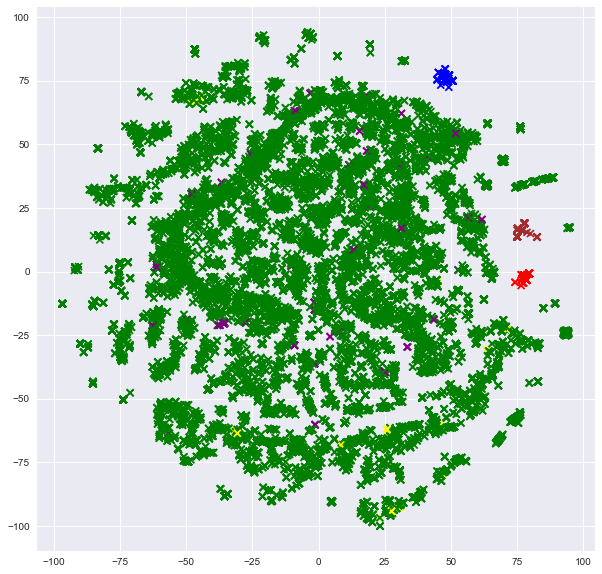

In [455]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x",c=colors)
plt.show()

#### Hierarchical Clustering

In [460]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import mpl_toolkits.mplot3d.axes3d as p3
from __future__ import print_function, division
from builtins import range
import time

In [457]:
###Lazy Programmer Method! Sample Data for Faster Results
X = tfidf_vectorizer.fit_transform(final_tweets).todense()
N = tfidf_matrix.shape[0]
idx = np.random.choice(N, size=5000, replace=False) # subsampe for efficiency
x = X[idx]

/Users/hector/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Condense our Matrix into array for visualizations

In [458]:
#dist_array = pdist(x) ## Euclidean dist

In [461]:
dist_array2 = pdist(x, 'cosine') ## Cosine dist

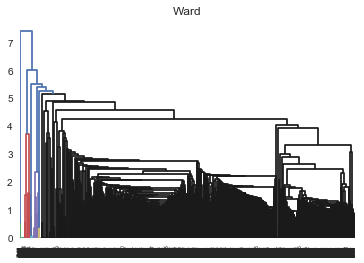

In [463]:
Z = linkage(dist_array2, 'ward')
plt.title("Ward")
dendrogram(Z,)
plt.savefig('Dendogram.png')
plt.show()

SKLearn method of visualizing 3-D hierarchical clustering

In [464]:
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(x)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 353.40s
Number of points: 5000


In [581]:
len(final_tweets)

45150

In [150]:
type(tsne_tweets)

numpy.ndarray

In [151]:
type(nmf_reduced)

numpy.ndarray

In [153]:
np.savetxt("nmf.csv", nmf_reduced, delimiter=",")

In [156]:
df_reduced.to_csv('NMF_model.csv')

In [ ]:
df_reduced.tail(25)

In [169]:
nmf

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
  n_components=15, random_state=1, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)